In [12]:
import numpy as np

gamma = 1.15

P0 = 101325
P1 = 2e5

M2 = np.sqrt((2 / (gamma - 1)) * ((P1 / P0)**((gamma - 1)/gamma) - 1))
PRC = ((gamma + 1)/2)**(-gamma/(gamma-1))
PRI = P0/P1


PRatio_2_sho = (1 + (2 * gamma / (gamma + 1)) * (M2**2 - 1))
PRatio_2_exp = ((1 + (gamma - 1)/2 * M2**2)**(gamma/(gamma - 1)))

PRC, PRI ,'Choked' if PRC > PRI else 'Not Choked', PRatio_2_sho/PRatio_2_exp, M2

(0.5743832598179436,
 0.506625,
 'Choked',
 0.6348609395508339,
 1.1120298399185233)

In [26]:
import gmsh

gmsh.initialize()

# Crear un nuevo modelo
gmsh.model.add("Tobera")

# Definir los puntos (x, y)
L_inlet = 5
D_throat = 2
D_exit = 5
L_outlet = 15

p1 = gmsh.model.geo.addPoint(0, D_throat/2, 0)
p2 = gmsh.model.geo.addPoint(L_inlet, D_throat/2, 0)
p3 = gmsh.model.geo.addPoint(L_inlet, D_exit/2, 0)
p4 = gmsh.model.geo.addPoint(L_outlet, D_exit/2, 0)
p5 = gmsh.model.geo.addPoint(L_outlet, 0, 0)
p6 = gmsh.model.geo.addPoint(0, 0, 0)

# Conectar puntos con líneas
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
l5 = gmsh.model.geo.addLine(p5, p6)
l6 = gmsh.model.geo.addLine(p6, p1)

# Crear curva compuesta para la cara
gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5, l6], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

gmsh.model.geo.synchronize()

# Refinamiento de malla en diferentes partes de la geometría
gmsh.model.mesh.setTransfiniteCurve(l1, 50)
gmsh.model.mesh.setTransfiniteCurve(l2, 30)
gmsh.model.mesh.setTransfiniteCurve(l3, 50)
gmsh.model.mesh.setTransfiniteCurve(l4, 50)
gmsh.model.mesh.setTransfiniteCurve(l5, 50)
gmsh.model.mesh.setTransfiniteCurve(l6, 50)

# Crear la malla
gmsh.model.mesh.generate(2)

# Guardar el archivo .msh
gmsh.write("tobera.msh")

# Finalizar Gmsh
gmsh.finalize()



In [2]:
import pyqtgraph as pg
from PyQt5.QtWidgets import QApplication, QMainWindow
import numpy as np
import sys

class GaugePlot(QMainWindow):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        # Configurar la ventana principal
        self.setWindowTitle('Gauge Plot with PyQtGraph')
        self.setGeometry(100, 100, 800, 600)

        # Crear un widget de gráfica
        self.plot_widget = pg.PlotWidget(self)
        self.setCentralWidget(self.plot_widget)

        # Configurar el gráfico del gauge
        self.plot_item = self.plot_widget.plot()

        # Configuración inicial de los valores
        self.instValues = [0.5, 0.5, 0.5, 0.5]
        self.maxValues = [1, 1, 1, 1]

        # Programar las actualizaciones
        self.timer = pg.QtCore.QTimer()
        self.timer.timeout.connect(self.update_gauge_plot)
        self.timer.start(100)  # Actualizar cada 100 ms

    def update_gauge_plot(self):
        """Función de actualización para el gráfico del gauge."""
        # Calcular los valores de los gauges
        x = np.linspace(-1.8, 1.8, 100)
        y = np.sin(x * np.pi * self.instValues[0])  # Ejemplo de actualización dinámica

        # Actualizar la gráfica
        self.plot_item.setData(x, y)  # Reutilizar el objeto de datos

if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = GaugePlot()
    window.show()
    sys.exit(app.exec_())


SystemExit: 0

C:\Users\marco\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


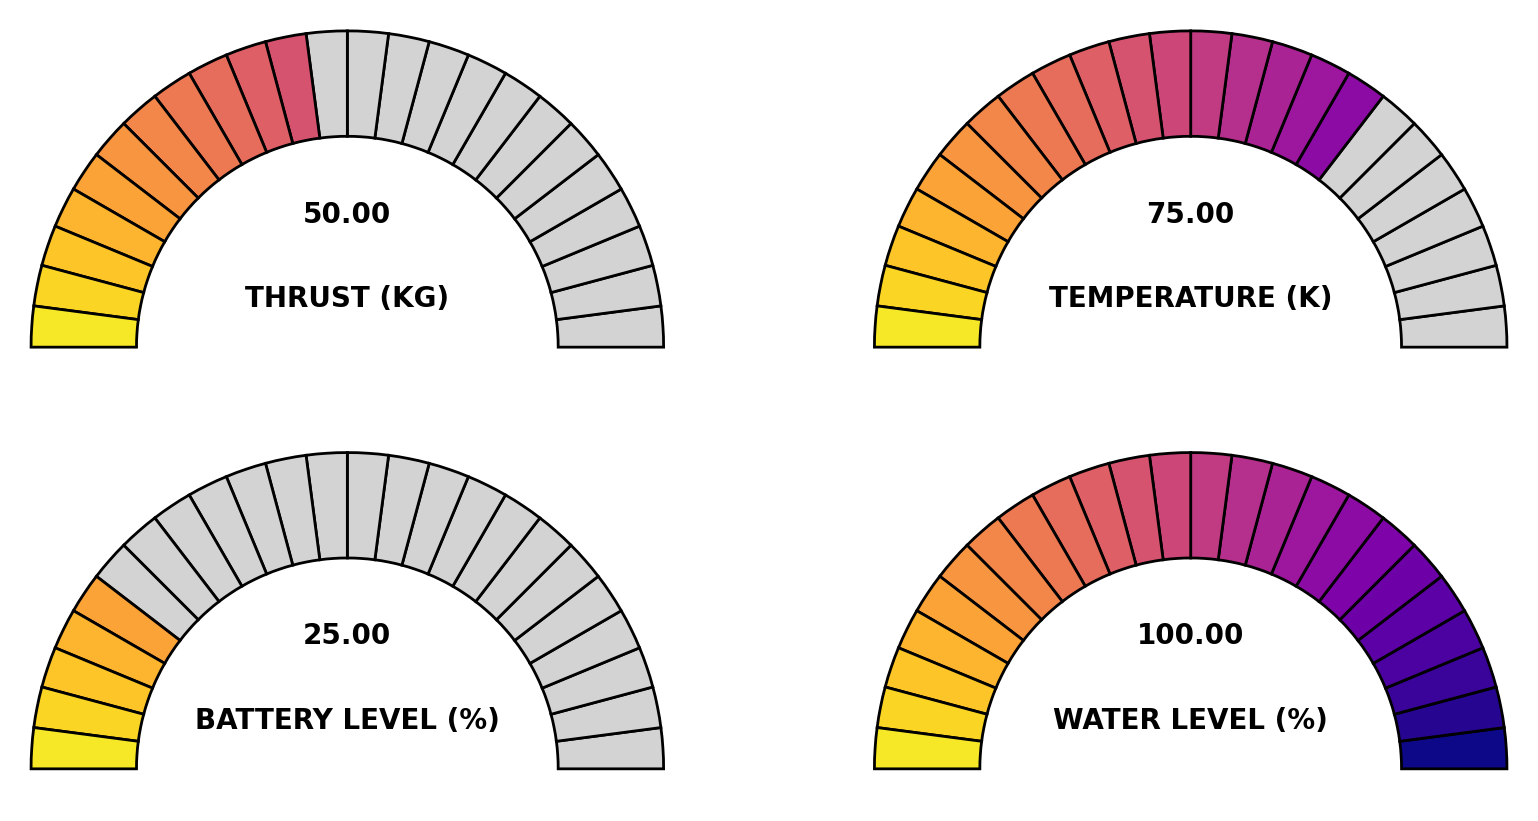

In [131]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def gaugePlot(instValues, maxValues=[0,0,0,0]):
    fig, ax = plt.subplots(figsize=(16, 16))

    # Create a color gradient around the outer circle edge
    n = 25  # Number of segments for the gradient
    cmap = plt.get_cmap('plasma')  # Color map
    delta = 0
    theta = np.linspace(0 - delta, np.pi + delta, n)  # Divide the semicircle into 'n' segments

    x = 1
    y = 0.5
    ri = 0.75
    w = 0.25
    edgCol = 'k'

    instValues = np.array(instValues)
    maxValues = np.array(maxValues)
    percValues = instValues / maxValues

    # Loop over the four positions to plot the gauges
    for j, perc in enumerate(percValues):
        # Determine the number of wedges to fill based on the percentage
        num_fill = int(n * perc)  # Calculate the number of wedges to fill

        # Determine the position offsets for each gauge
        if j == 0:
            x_pos, y_pos = -x, y
        elif j == 1:
            x_pos, y_pos = x, y
        elif j == 2:
            x_pos, y_pos = -x, -y
        else:
            x_pos, y_pos = x, -y

        for i in range(n - 1):
            # Set the color for each wedge
            if num_fill > 0 and i >= (n - num_fill):
                color = cmap(i / (n - 1))  # Fill wedges in reverse order
            else:
                color = 'lightgrey'  # Set the remaining wedges to light grey

            # Create the wedges with the corresponding color
            wedge = patches.Wedge(center=(x_pos, y_pos), r=ri, theta1=np.degrees(theta[i]),
                                  theta2=np.degrees(theta[i + 1]), width=w, facecolor=color, edgecolor=edgCol, linewidth=2)
            ax.add_patch(wedge)



        ## Add text inside the rectangles for the current value
        #ax.text(x_pos, y_pos + (1.15 * ri if y_pos > 0 else -1.25 * ri),
        #        f"{instValues[j]:.2f}", ha='center', va='center', fontsize=20, fontweight='bold')
        
        # Add the shapes to the plot
  

    # Add text to the rectangles
    ax.text(-x, 1.6 * y + 0.02 * ri    , f"{instValues[0]:.2f}", ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x, 1.6 * y + 0.02 * ri     , f"{instValues[1]:.2f}", ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(-x, 0.4 * -y + 0.02 * ri   , f"{instValues[2]:.2f}", ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x, 0.4 * -y + 0.02 * ri    , f"{instValues[3]:.2f}", ha='center', va='center', fontsize=20, fontweight='bold')

    ax.text(-x, 1.6 * y + 0.02 * ri    - 0.2, "THRUST (KG)"       , ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x, 1.6 * y + 0.02 * ri     - 0.2, "TEMPERATURE (K)"   , ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(-x, 0.4 * -y + 0.02 * ri   - 0.2, "BATTERY LEVEL (%)" , ha='center', va='center', fontsize=20, fontweight='bold')
    ax.text(x, 0.4 * -y + 0.02 * ri    - 0.2, "WATER LEVEL (%)"   , ha='center', va='center', fontsize=20, fontweight='bold')

    # Fix the percentage to the range [0, 1] so it does not exceed the maximum angle

    # Adjust axis scales so the circle does not get deformed
    ax.set_aspect('equal', 'box')

    # Set axis limits
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-0.6, 1.3)
    fig.tight_layout()
    ax.set_axis_off()

    return fig

# Example usage
percent = [50, 75, 25, 100]

gaugePlot(percent, maxValues=[100,100,100,100])  # Example with percentage greater than 100%
plt.show()


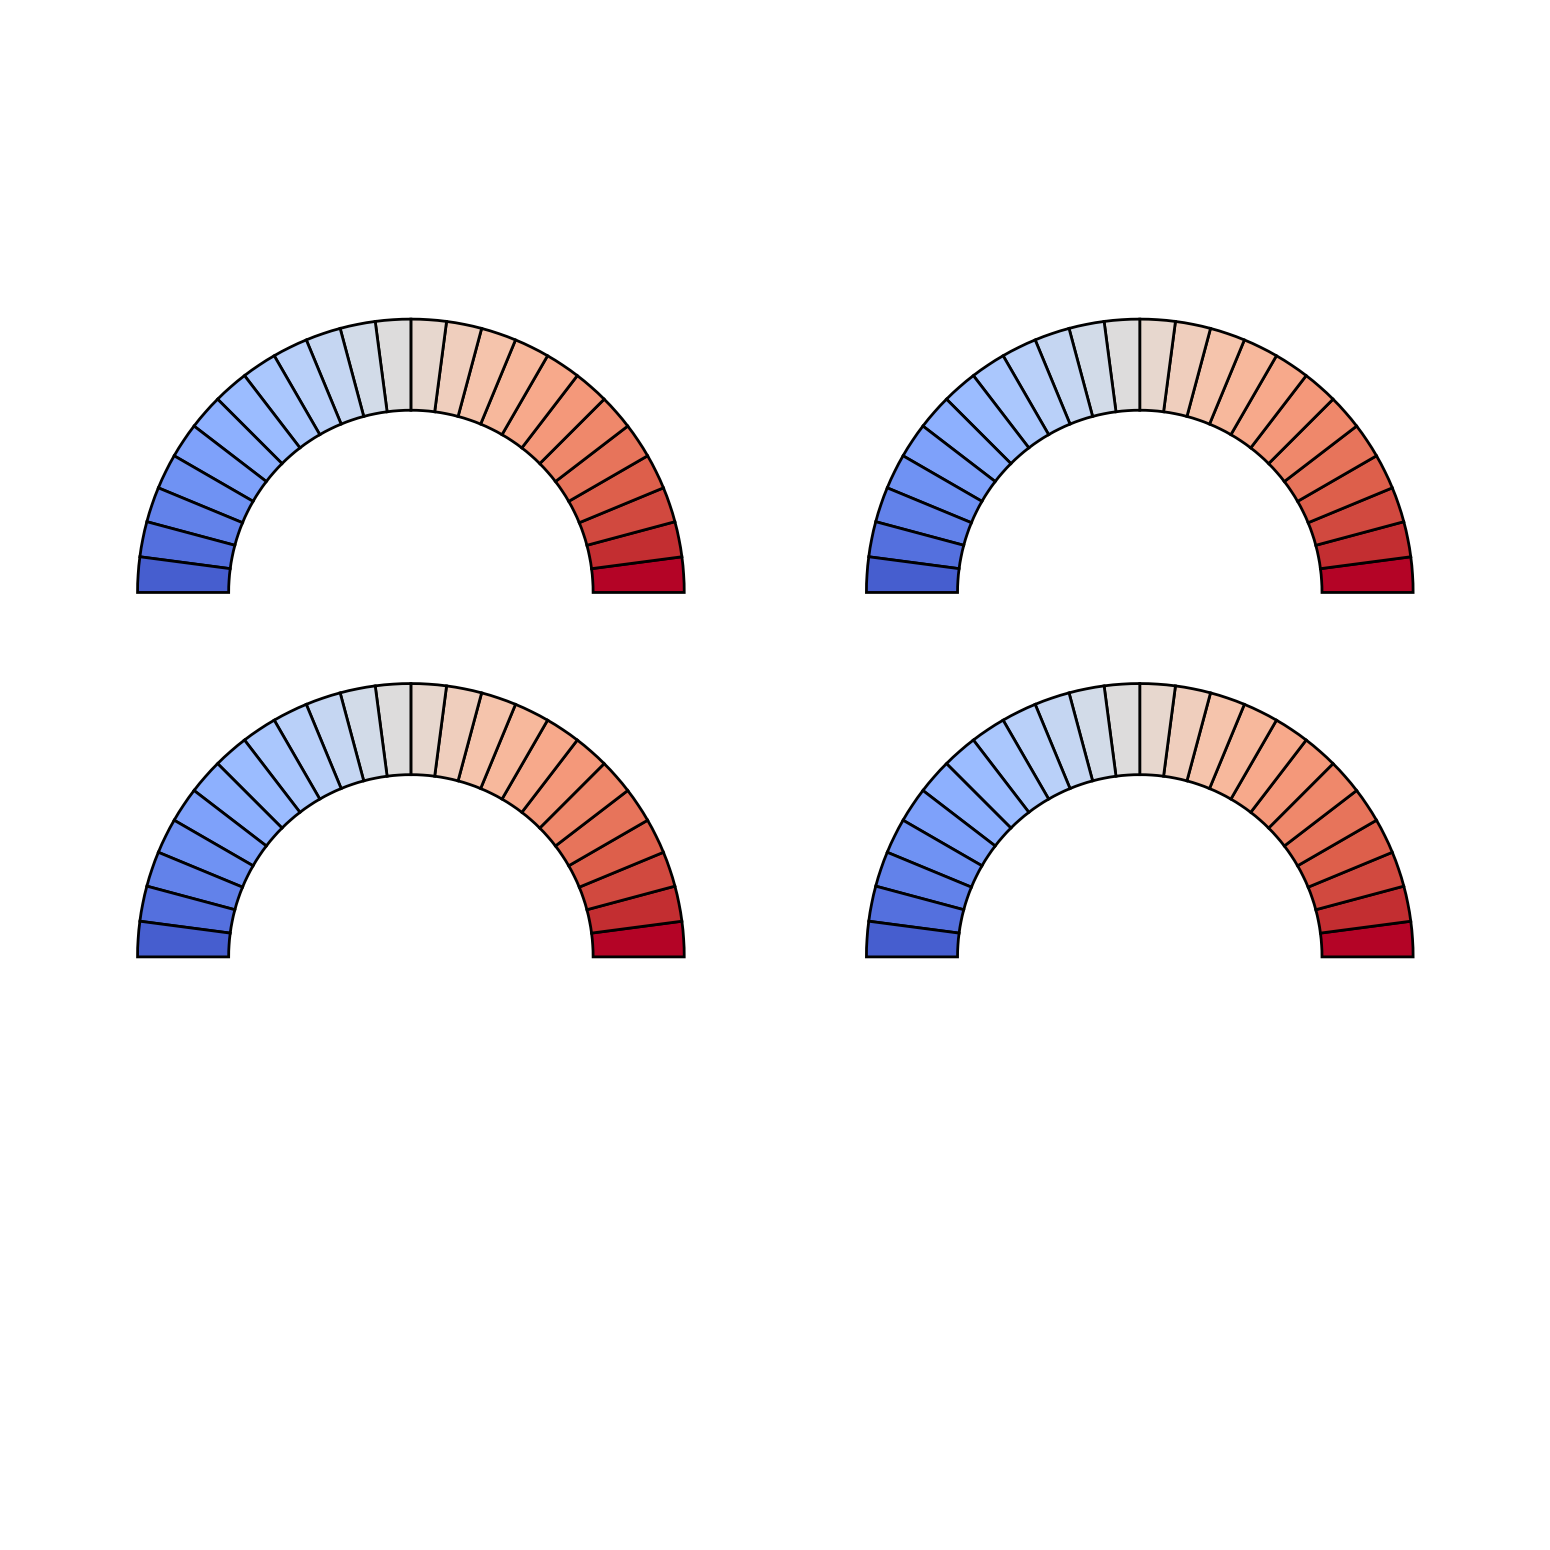

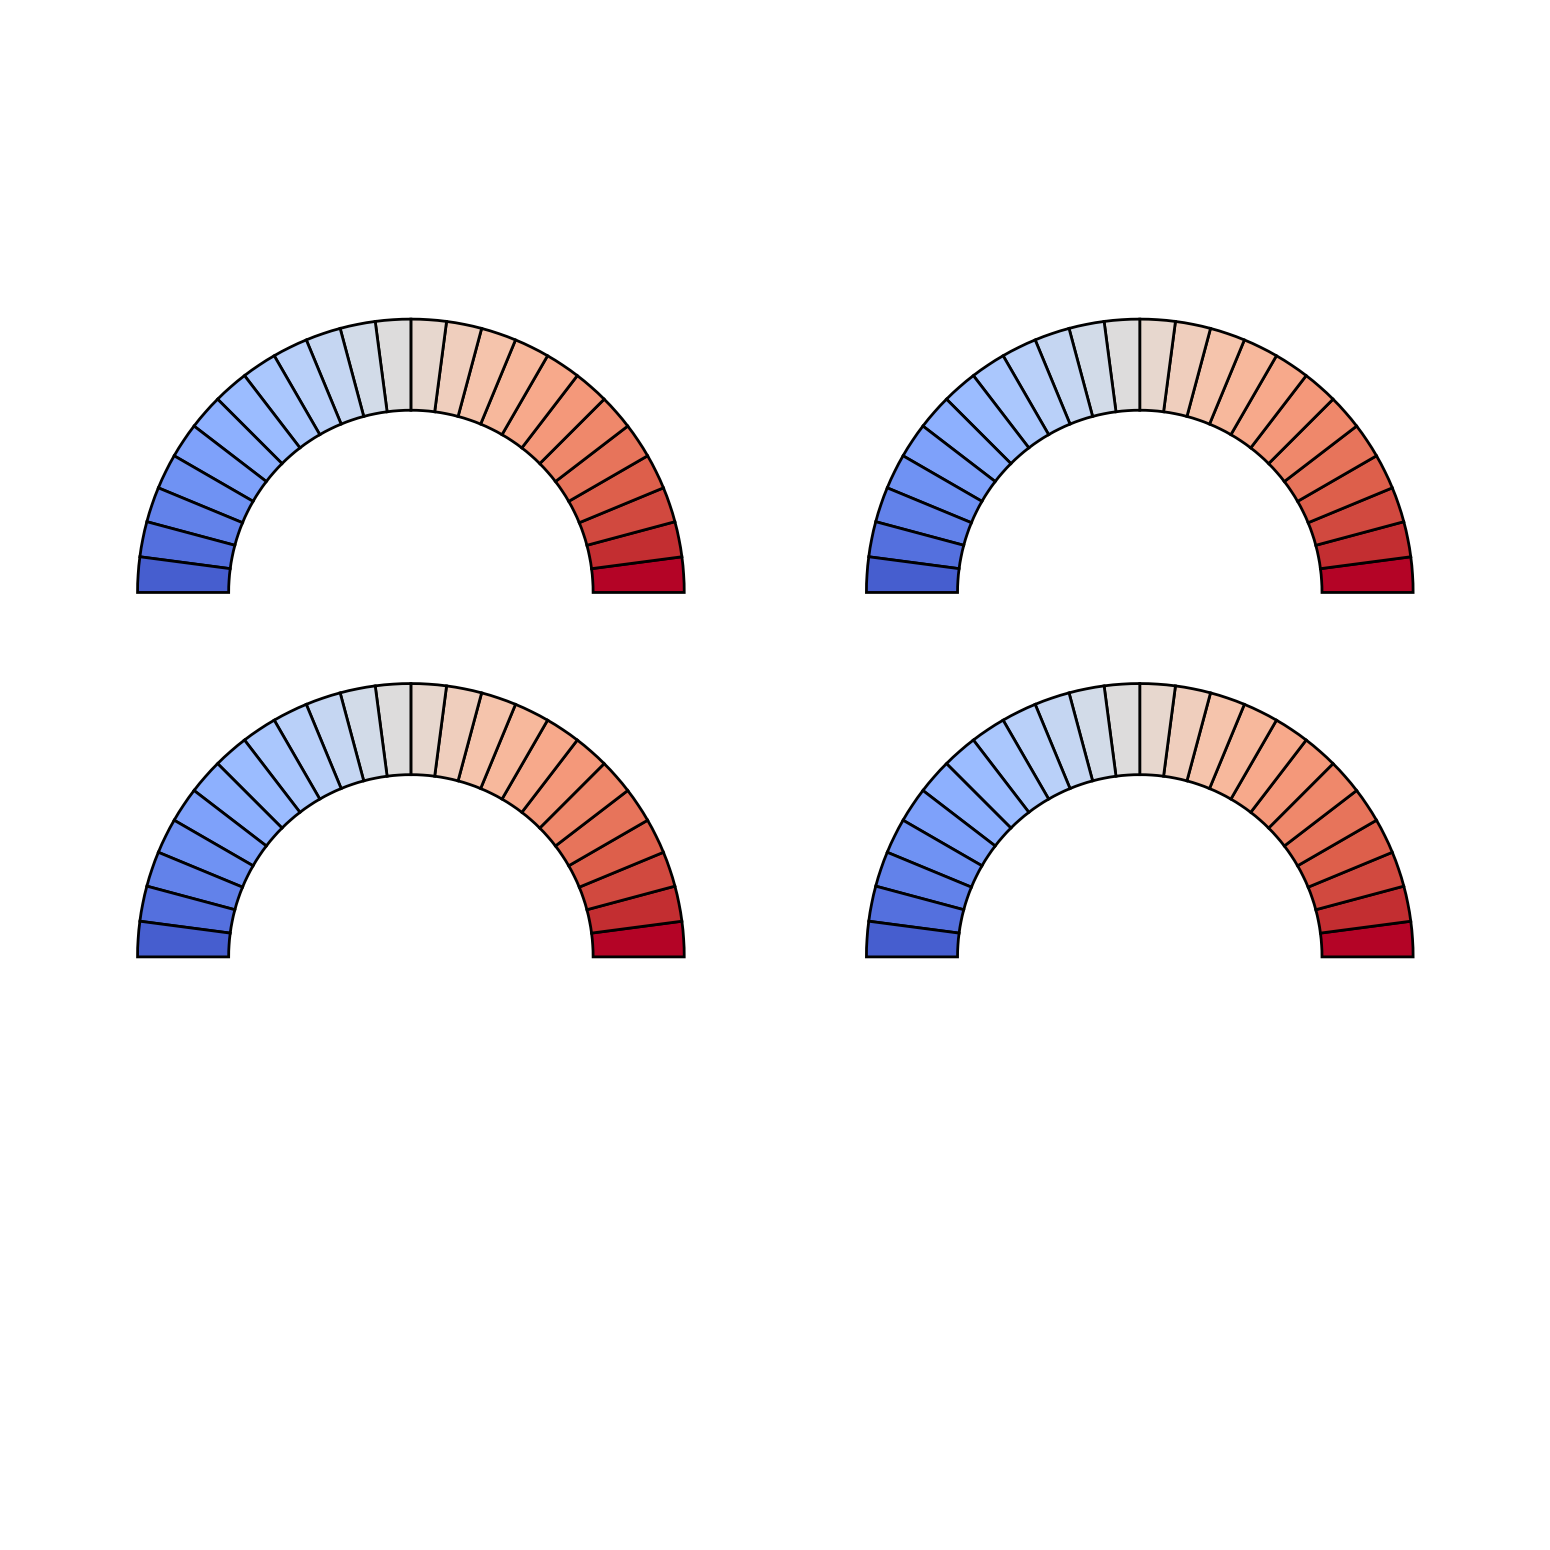

In [85]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def gaugePlot(perc, magnitude, units=None, maxValue=0):
    fig, ax = plt.subplots(figsize=(16, 16))

    # Crear un gradiente de colores alrededor del borde del círculo exterior
    n = 25  # Número de segmentos para el degradado
    cmap = plt.get_cmap('coolwarm')  # Mapa de colores
    theta = np.linspace(0, np.pi, n)  # Dividir el semicírculo en 'n' segmentos

    x = 1
    y = 0.5
    ri = 0.75
    w = 0.25

    for i in range(n-1):
        # Invertir el orden de los colores del gradiente
        color = cmap((n - 1 - i) / (n - 1))  # Obtener el color en orden inverso

        wedge_11 = patches.Wedge(center=(-x, y), r=ri, theta1=np.degrees(theta[i]), 
                              theta2=np.degrees(theta[i+1]), width=w, facecolor=color, edgecolor='black', linewidth=2)
        
        wedge_12 = patches.Wedge(center=(x, y), r=ri, theta1=np.degrees(theta[i]), 
                              theta2=np.degrees(theta[i+1]), width=w, facecolor=color, edgecolor='black', linewidth=2)
        
        wedge_21 = patches.Wedge(center=(-x, -y), r=ri, theta1=np.degrees(theta[i]), 
                              theta2=np.degrees(theta[i+1]), width=w, facecolor=color, edgecolor='black', linewidth=2)
        
        wedge_22 = patches.Wedge(center=(x, -y), r=ri, theta1=np.degrees(theta[i]), 
                              theta2=np.degrees(theta[i+1]), width=w, facecolor=color, edgecolor='black', linewidth=2)
        
        ax.add_patch(wedge_11)
        ax.add_patch(wedge_12)
        ax.add_patch(wedge_21)
        ax.add_patch(wedge_22)

    # Limitar el porcentaje al rango [0, 1] para que no exceda el ángulo máximo
    perc_fix = min(perc, 1)

    # Calcular la posición de la aguja
    needle_angles = np.pi * (1 - perc_fix)

    
    #ax.annotate(str(int(perc * maxValue)), xytext=(x, y), 
    #            xy=(x  + (ri-w) * np.cos(needle_angles), y + (ri-w) * np.sin(needle_angles)),
    #            arrowprops=dict(arrowstyle="wedge, tail_width=0.8", color="black", shrinkA=10),
    #            bbox=dict(boxstyle="circle", facecolor="black", linewidth=1),
    #            fontsize=20, color="white", ha="center")
    
    # Agregar el título justo debajo del gráfico
    #if maxValue != 0:
    #    ax.text(0.5, -0.1,  f'Max. {magnitude}: {maxValue} {units}', ha='center', va='center', fontsize=20, fontweight='bold', transform=ax.transAxes)
    #else:
    #    ax.text(0.5, -0.1, magnitude, ha='center', va='center', fontsize=20, fontweight='bold', transform=ax.transAxes)


    # Ajustar las escalas de los ejes para que el círculo no se deforme
    ax.set_aspect('equal', 'box')

    # Configurar los límites de los ejes
    ax.set_xlim(-2.1, 2.1)
    ax.set_ylim(-2.1, 2.1)
    fig.tight_layout()
    ax.set_axis_off()

    return fig

# Ejemplo de uso
gaugePlot(1.2, "THRUST (KG)", 1700)


In [70]:
import numpy as np

class TempSchemes:
    
    @staticmethod
    def Euler(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        return u + h * k1
    
    @staticmethod
    def Heun(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + k1 * h) for fi in f])
        return u + h * (k1 + k2) / 2
    
    @staticmethod
    def RK4(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + 0.5 * k1 * h) for fi in f])
        k3 = np.array([fi(u + 0.5 * k2 * h) for fi in f])
        k4 = np.array([fi(u + k3 * h) for fi in f])
        return u + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def solve_ode_system(f_system, u0, h, method, t_max, divergence_threshold=1e6, stop_conditions=None, indefinite=False):
    """
    General solver for a system of differential equations.
    
    Parameters:
    - f_system: list of functions defining the system of ODEs.
    - u0: initial conditions as a list or numpy array.
    - h: step size.
    - method: string, "Euler", "Heun", or "RK4".
    - t_max: maximum time for the simulation.
    - divergence_threshold: optional float, threshold for divergence detection.
    - stop_conditions: optional list of functions, each taking the current state as input and returning a boolean.
    - indefinite: boolean, if True the simulation will run indefinitely until a stop condition is met.
    
    Returns:
    - sol: numpy array with the solution for each variable over time.
    - t: numpy array with the time points.
    """
    schemes = {
        "Euler": TempSchemes.Euler,
        "Heun": TempSchemes.Heun,
        "RK4": TempSchemes.RK4
    }
    
    if method not in schemes:
        raise ValueError("Method should be 'Euler', 'Heun', or 'RK4'")
    
    num_steps = int(t_max / h) + 1 if t_max else 1000  # Initial allocation, will expand if indefinite is True
    sol = np.zeros((num_steps, len(u0)))
    sol[0] = u0
    t = np.zeros(num_steps)
    
    i = 1
    while True:
        if not indefinite and i >= num_steps:
            break
        
        if indefinite and i >= num_steps:
            # Expand arrays if running indefinitely
            sol = np.vstack([sol, np.zeros((1000, len(u0)))])
            t = np.hstack([t, np.zeros(1000)])
            num_steps += 1000

        sol[i] = schemes[method](f_system, sol[i-1], h)
        t[i] = t[i-1] + h
        print(t[i], sol[i][0], sol[i][1])
        
        # Check for divergence
        if np.any(np.abs(sol[i] - sol[i-1]) > divergence_threshold):
            print("Simulation stopped due to divergence.")
            break
        
        # Check for custom stop conditions
        if stop_conditions:
            if any(condition(sol[i]) for condition in stop_conditions):
                print("Simulation stopped due to custom stop condition.")
                break
        
        i += 1
    
    # Trim the arrays to the actual size
    sol = sol[:i]
    t = t[:i]
    
    return sol, t


In [ ]:

# Example of usage:
# Define a system of ODEs, e.g., a simple harmonic oscillator
def f1(u):
    return u[1]

def f2(u):
    k = 1.0  # Spring constant
    m = 1.0  # Mass
    return -k/m * u[0]

# Custom stop conditions example: stop if position exceeds 2 units or velocity exceeds 5 units
def stop_condition_position(state):
    return abs(state[0]) > 2

def stop_condition_velocity(state):
    return abs(state[1]) > 5

# Initial conditions: [position, velocity]
u0 = [1.0, 0.0]
h = 0.01
t_max = 10.0

# Solve the system using RK4 method with indefinite run
f_system = [f1, f2]
stop_conditions = [stop_condition_position, stop_condition_velocity]

sol, t = solve_ode_system(f_system, u0, h, "RK4", t_max, stop_conditions=stop_conditions, indefinite=False)

plt.plot(t, sol[:, 0])

In [119]:

inputs = [0.01, 0.025, 0.005, 0.1, 1400, 0.01356, 0.3, 1.15, 223, 1800, 0, 1e8, 1000, 0.01, 101325]

def discreteIntegration(fs, xs):
    return sum([(xs[i+1] - xs[i]) * (fs[i+1] + fs[i]) / 2 for i in range(len(fs)-1)])

class TempSchemes:
    
    @staticmethod
    def Euler(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        return u + h * k1
    
    @staticmethod
    def Heun(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + k1 * h) for fi in f])
        return u + h * (k1 + k2) / 2
    
    @staticmethod
    def RK4(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + 0.5 * k1 * h) for fi in f])
        k3 = np.array([fi(u + 0.5 * k2 * h) for fi in f])
        k4 = np.array([fi(u + k3 * h) for fi in f])
        return u + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def numerical_derivative(x, f):
    """
    Computes the numerical derivative of a function given by arrays of x and f values.
    
    Parameters:
    - x: array of x values (independent variable).
    - f: array of f values (dependent variable).
    
    Returns:
    - df_dx: array of the numerical derivative df/dx.
    """
    if len(x) != len(f):
        raise ValueError("The length of x and f must be the same")
    
    df_dx = np.zeros_like(f)
    
    # Central difference for the interior points
    df_dx[1:-1] = (f[2:] - f[:-2]) / (x[2:] - x[:-2])
    
    # Forward difference for the first point
    df_dx[0] = (f[1] - f[0]) / (x[1] - x[0])
    
    # Backward difference for the last point
    df_dx[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
    
    return df_dx

def solve_ode_system(f_system, u0, h, method, t_max, divergence_threshold=1e6, stop_conditions=None, indefinite=False):
    """
    General solver for a system of differential equations.
    
    Parameters:
    - f_system: list of functions defining the system of ODEs.
    - u0: initial conditions as a list or numpy array.
    - h: step size.
    - method: string, "Euler", "Heun", or "RK4".
    - t_max: maximum time for the simulation.
    - divergence_threshold: optional float, threshold for divergence detection.
    - stop_conditions: optional list of functions, each taking the current state as input and returning a boolean.
    - indefinite: boolean, if True the simulation will run indefinitely until a stop condition is met.
    
    Returns:
    - sol: numpy array with the solution for each variable over time.
    - t: numpy array with the time points.
    """
    schemes = {
        "Euler": TempSchemes.Euler,
        "Heun": TempSchemes.Heun,
        "RK4": TempSchemes.RK4
    }
    
    if method not in schemes:
        raise ValueError("Method should be 'Euler', 'Heun', or 'RK4'")
    
    num_steps = int(t_max / h) + 1 if t_max else 1000  # Initial allocation, will expand if indefinite is True
    sol = np.zeros((num_steps, len(u0)))
    sol[0] = u0
    t = np.zeros(num_steps)
    
    i = 1
    while True:
        if not indefinite and i >= num_steps:
            break
        
        if indefinite and i >= num_steps:
            # Expand arrays if running indefinitely
            sol = np.vstack([sol, np.zeros((1000, len(u0)))])
            t = np.hstack([t, np.zeros(1000)])
            num_steps += 1000

        sol[i] = schemes[method](f_system, sol[i-1], h)
        t[i] = t[i-1] + h
        
        # Check for divergence
        if np.any(np.abs(sol[i] - sol[i-1]) > divergence_threshold):
            print("Simulation stopped due to divergence.")
            break
        
        # Check for custom stop conditions
        if stop_conditions:
            if any(condition(sol[i]) for condition in stop_conditions):
                print("Simulation stopped due to custom stop condition.")
                messagebox.showinfo("Guardar archivo", "Simulation stopped due to custom stop condition.")
                break
        
        i += 1
    
    # Trim the arrays to the actual size
    sol = sol[:i]
    t = t[:i]
    
    return sol, t

class TubularGrain:
    def __init__(self, inputs):
        # Lista de atributos que quieres asignar
        attributes = [
            "rIn_0b", "rOut", "rThrt", "lComb", 
            "rho_b", "a", "n", "gamma", "R", "T1", "P1_min","P1_max", "cChar",
            "delta_r", "P0"
        ]
        
        for attr, value in zip(attributes, inputs):
            setattr(self, attr, value)

        self.sol, self.t = self.combTime()
        self.P = self.sol[:, 0]
        self.r = self.sol[:, 1]

        self.rDot = numerical_derivative(self.t, self.r)
        self.G = self.rho_b * self.Ab(self.r) * self.rDot
        self.M = self.lComb * np.pi * (self.rOut**2 - self.r**2) * self.rho_b

        self.meanPressure, self.meanMassFlow = self.mean_values()

        self.Pmin, self.Pmax = np.min(self.P), np.max(self.P)
        self.Gmin, self.Gmax = np.min(self.G), np.max(self.G)
        self.combustion_time = float(self.t[-1])
        self.combustion_mass = float(self.M[0])
        
    def Ab(self, r):
        return 2 * np.pi * r * self.lComb
        
    def Vc(self, r):
        return np.pi * r**2 * self.lComb

    def combTime(self):

    
        def P_dot(u):
            P, r = u
            term_0 = self.R * self.T1
            term_1 = (self.rho_b * self.a * P**self.n * 1e-2 * self.Ab(r)/self.Vc(r)) 
            term_2 = (P * np.pi * self.rThrt**2) / (self.cChar * self.Vc(r))
            return term_0 * (term_1 - term_2)

        def r_dot(u):
            P, r = u
            return self.a * P**self.n * 1e-2
        
        
        # Initial conditions: [position, velocity]
        u0 = [self.P0, self.rIn_0b]
        h = 0.001
        t_max = 10.0

        # Solve the system using RK4 method with indefinite run
        f_system = [P_dot, r_dot]

        def rMax_condition(state):
            P, r = state
            return r >= self.rOut
        
        def maxPressureLimit(state):
            P, r = state
            return P > self.P1_max
        
        def minPressureLimit(state):
            P, r = state
            return P < self.P1_min
        
        stop_conditions = [rMax_condition]#, maxPressureLimit, minPressureLimit]
        sol, t = solve_ode_system(f_system, u0, h, "RK4", t_max, stop_conditions=stop_conditions, indefinite=True)
        
        return sol, t
        
    
    def mean_values(self):
        interval = self.t[-1] - self.t[0]
        mean_pressure = float(discreteIntegration(self.P, self.t) / interval)
        mean_massflow = float(discreteIntegration(self.G, self.t) / interval)
        return mean_pressure, mean_massflow
    
    def pressureGraph(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.t, self.P, label='Pressure',linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Pressure (Pa)')
        ax.set_title('Pressure vs Time')
        ax.grid(True)
        return fig

    def massFlowGraph(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.t, self.G, label='Mass Flow Rate',linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Mass Flow Rate (kg/s)')
        ax.set_title('Mass Flow Rate vs Time')
        ax.grid(True)
        return fig

    def massTimeGraph(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.t, self.M, label='Mass',linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Mass (kg)')
        ax.set_title('Mass vs Time')
        ax.grid(True)
        return fig


test = TubularGrain(inputs)
test.meanPressure

Simulation stopped due to custom stop condition.


2040927.2012541154